In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sklearn.datasets as datasets
import sklearn.decomposition as decomposition
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
import sklearn.model_selection as crossval

In [2]:
def plot_params(mod, ax=None):
    if ax is None:
        ax = plt.gca()
    param = np.asarray(mod.param[1:])
    ymax = param.copy()
    ymin = param.copy()
    n = len(param)
    np.putmask(ymax, param<0, 0)
    np.putmask(ymin, param>0, 0)
    ax.vlines(range(n), ymin, ymax, color='k', linewidth=1., label=r"Вектор коэффициентов $\mathbf{w}$")
    ax.minorticks_on()
    ax.set_ylabel(r"$w_k$")
    ax.legend(loc="upper right")


In [3]:
iris = datasets.load_iris()
X = iris.data
Y = iris.target
feature_names = iris.feature_names
class_names = iris.target_names
print("Instances:", len(X))
print("Class names:", class_names)
print("Feature names", feature_names)

Instances: 150
Class names: ['setosa' 'versicolor' 'virginica']
Feature names ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


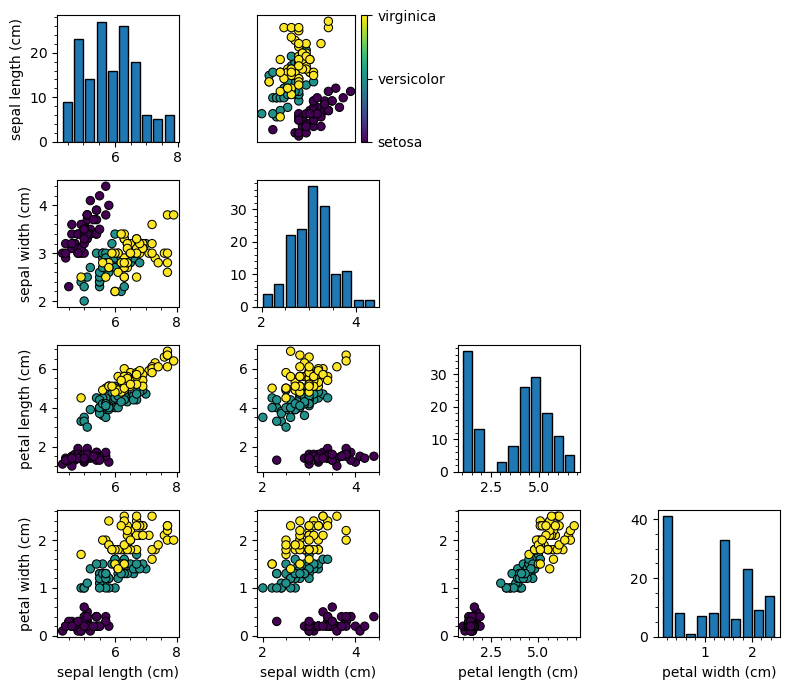

In [4]:
plt.figure(figsize=(8,7))
for i in range(4):
    for j in range(4):
        if i == 1 and j == 0:
            plt.subplot(4, 4, 4*j+i+1)
            cs = plt.scatter(X[:,i], X[:,j], c=Y, edgecolors='k', s=36, linewidths=0.75)
            plt.xticks([])
            plt.yticks([])
            cb = plt.colorbar(cs, ticks=[0,1,2])
            cb.set_ticklabels(class_names)
        if i > j:
            continue
        plt.subplot(4, 4, 4*j+i+1)
        if i == 0:
            plt.ylabel(feature_names[j])
        if j == 3:
            plt.xlabel(feature_names[i])
        if i == j:
            plt.hist(X[:,i], rwidth=0.8, edgecolor='k')
        elif i < j:
            plt.scatter(X[:,i], X[:,j], c=Y, edgecolors='k', s=36, linewidths=0.75)
        plt.minorticks_on()
            
plt.tight_layout()
plt.show()

In [5]:
X2 = X[Y != 0]
Y2 = Y[Y != 0]
np.putmask(Y2, Y2 == 1, -1)
np.putmask(Y2, Y2 == 2, +1)
Y2 = np.ascontiguousarray(Y2, "d")
X2 = np.ascontiguousarray(X2, "d")
N = len(Y2)

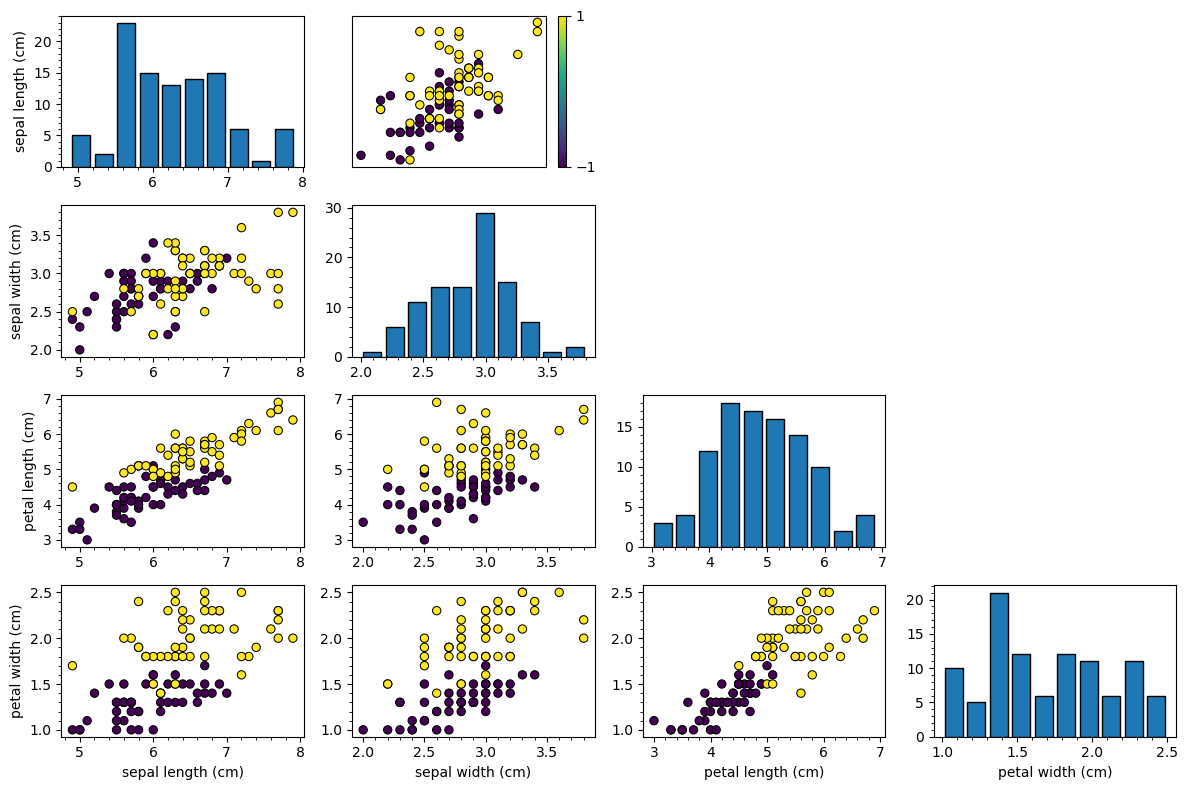

In [6]:
plt.figure(figsize=(12,8))
for i in range(4):
    for j in range(4):
        if i == 1 and j == 0:
            plt.subplot(4, 4, 4*j+i+1)
            cs = plt.scatter(X2[:,i], X2[:,j], c=Y2, edgecolors='k', s=36, linewidths=0.75)
            plt.xticks([])
            plt.yticks([])
            cb = plt.colorbar(cs, ticks=[-1, +1])
            # cb.set_ticklabels(class_names)
        if i > j:
            continue
        plt.subplot(4, 4, 4*j+i+1)
        if i == 0:
            plt.ylabel(feature_names[j])
        if j == 3:
            plt.xlabel(feature_names[i])
        if i == j:
            plt.hist(X2[:,i], rwidth=0.8, edgecolor='k')
        elif i < j:
            plt.scatter(X2[:,i], X2[:,j], c=Y2, edgecolors='k', s=36, linewidths=0.75)
        plt.minorticks_on()
            
plt.tight_layout()
plt.show()

In [7]:
import mlgrad.regr as regr
import mlgrad.plots as plots
import mlgrad.models as models
import mlgrad.funcs as funcs
import mlgrad.funcs2 as funcs2
import mlgrad.loss as loss
import mlgrad.gd as gd

In [8]:
mod = models.SigmaNeuronModel(funcs.Sigmoidal(5.0), 4)

In [9]:
alg = regr.regression(X2, Y2, mod, 
                        loss_func=loss.MarginLoss(funcs.Hinge(1.0)), 
                        regnorm=funcs2.SquareNorm(1), tau=0.01,
                        # normalizer=gd.Masked(mod, 1.0e-8),
                        h=0.01, n_iter=1000)
print(np.asarray(mod.param))
print("Accuracy score:", metrics.accuracy_score(np.sign(mod.evaluate(X2)), Y2))

[-2.159 -0.526 -0.505  1.013  1.171]
Accuracy score: 0.98


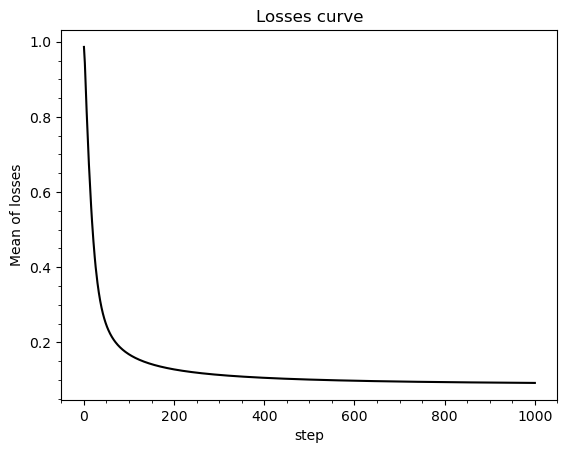

In [10]:
plots.plot_losses(alg)

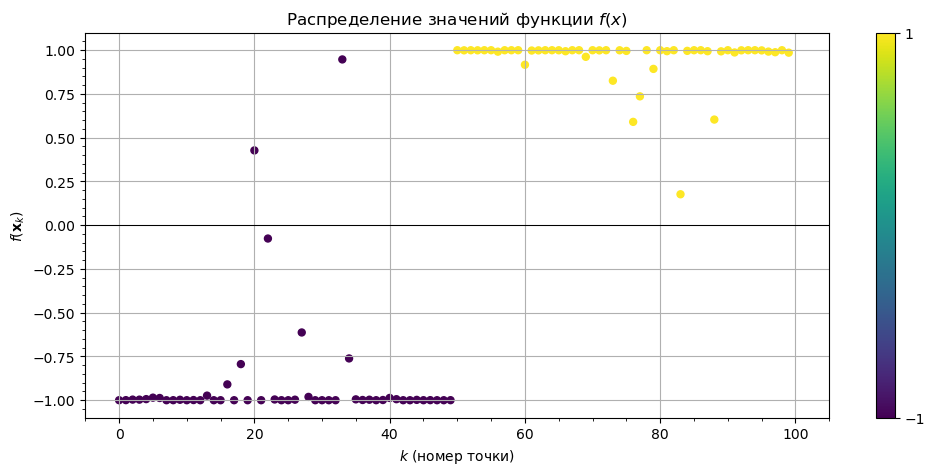

In [11]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod, X2, Y2)
plt.show()

train: 0.9666666666666667
test: 0.95


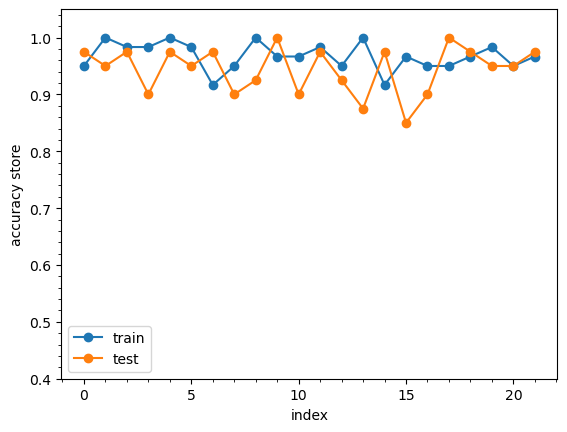

In [12]:
cv = crossval.StratifiedShuffleSplit(22, test_size=0.4)
scores_train = []
scores_test = []
for I_train, I_test in cv.split(X2, Y2):
    X_train = np.ascontiguousarray(X2[I_train])
    X_test = np.ascontiguousarray(X2[I_test])
    Y_train = np.ascontiguousarray(Y2[I_train])
    Y_test = np.ascontiguousarray(Y2[I_test]) 
    # mod = models.LinearModel(4)
    mod = models.SigmaNeuronModel(funcs.Sigmoidal(6.0), 4)
    alg = regr.regression(X_train, Y_train, mod,
                        loss_func=loss.MarginLoss(funcs.Hinge(0.0)),
                        regnorm=funcs2.SquareNorm(1), tau=0.01,
                        # normalizer=gd.Masked(mod, 1.0e-8),
                        h=0.01, n_iter=1000)
    sc_train = metrics.accuracy_score(np.sign(mod.evaluate(X_train)), Y_train)
    sc_test = metrics.accuracy_score(np.sign(mod.evaluate(X_test)), Y_test)
    scores_train.append(sc_train)
    scores_test.append(sc_test)

print("train:", np.median(scores_train))
print("test:", np.median(scores_test))

plt.plot(scores_train, marker='o', label="train")
plt.plot(scores_test, marker='o', label="test")
plt.ylim(0.4, 1.05)
plt.xlabel("index")
plt.ylabel("accuracy store")
plt.legend()
plt.minorticks_on()
plt.show()


In [13]:
def create_nn(n_hidden=100, tau=0):
    body = models.FFNetworkModel()
    body.add(models.LinearLayer(4, n_hidden))
    body.add(models.ScaleLayer(funcs.Sigmoidal(5.0), n_hidden))
    head = models.LinearModel(n_hidden)
    mod_nn = models.FFNetworkFuncModel(head, body)

    mod_nn.allocate()
    mod_nn.init_param()

    body[0].use_regularizer(funcs2.SquareNorm(), tau)

    return mod_nn

In [28]:
mod_nn = create_nn(100, 0.001)

In [29]:
alg_nn = regr.regression(X2, Y2, mod_nn,
                        loss_func=loss.MarginLoss(funcs.Hinge(1.0)),
                        # normalizer=gd.Masked(mod_nn, 1.0e-9),
                        h=0.01, n_iter=5000)
# print(np.asarray(mod_nn.param))
print("Accuracy score:", metrics.accuracy_score(np.sign(mod_nn.evaluate(X2)), Y2))

Accuracy score: 0.98


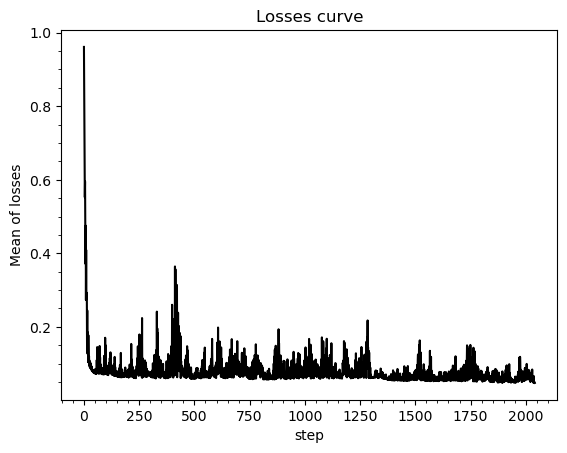

In [30]:
plots.plot_losses(alg_nn)

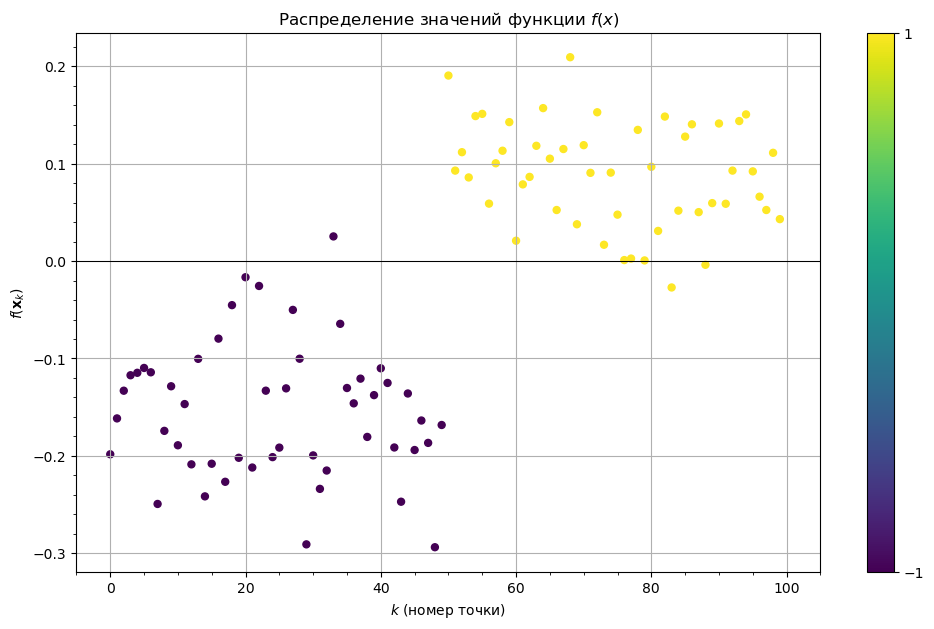

In [23]:
plt.figure(figsize=(12,7))
plots.plot_cls_function(mod_nn, X2, Y2)
plt.show()

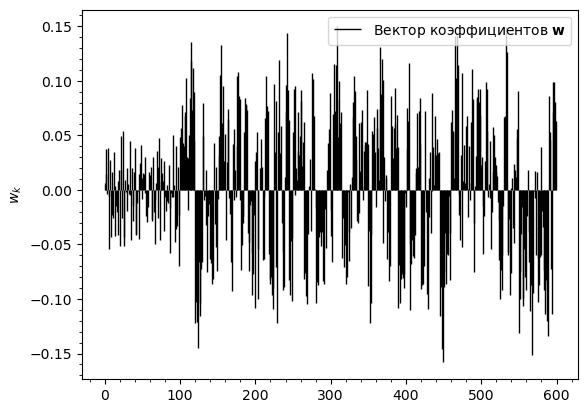

In [24]:
plot_params(mod_nn)

train: 0.9166666666666667
test: 0.925


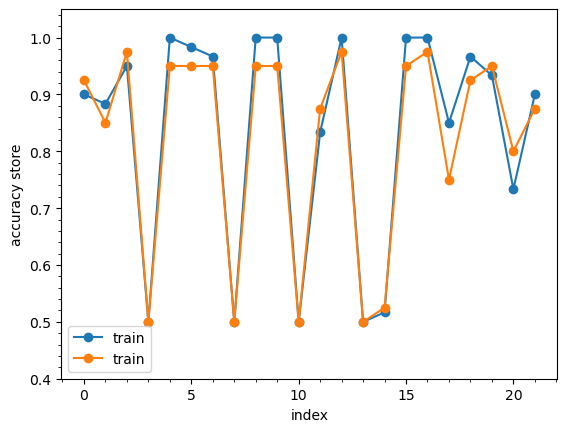

In [27]:
cv = crossval.StratifiedShuffleSplit(22, test_size=0.4)
scores_train = []
scores_test = []
for I_train, I_test in cv.split(X2, Y2):
    X_train = np.ascontiguousarray(X2[I_train])
    X_test = np.ascontiguousarray(X2[I_test])
    Y_train = np.ascontiguousarray(Y2[I_train])
    Y_test = np.ascontiguousarray(Y2[I_test]) 
    mod_nn = create_nn(100)
    alg_nn = regr.regression(X_train, Y_train, mod_nn,
                        loss_func=loss.MarginLoss(funcs.Hinge(1.0)),
                        regnorm=funcs2.SquareNorm(1), tau=0.01,
                        # normalizer=gd.Masked(mod_nn, 1.0e-8),
                        h=0.01, n_iter=1000, n_restart=3)
    sc_train = metrics.accuracy_score(np.sign(mod_nn.evaluate(X_train)), Y_train)
    sc_test = metrics.accuracy_score(np.sign(mod_nn.evaluate(X_test)), Y_test)
    scores_train.append(sc_train)
    scores_test.append(sc_test)

print("train:", np.median(scores_train))
print("test:", np.median(scores_test))

plt.plot(scores_train, marker='o', label="train")
plt.plot(scores_test, marker='o', label="train")
plt.ylim(0.4, 1.05)
plt.xlabel("index")
plt.ylabel("accuracy store")
plt.legend()
plt.minorticks_on()
plt.show()
